In [1]:
!pip install -qq datasets monai pydicom fsspec==2025.3.2 nibabel itk pydicom opencv-python memory_profiler

In [2]:
%load_ext memory_profiler

In [3]:
# Import necessary libraries.

import re
import gc
import torch
import torchvision as tv
import numpy as np
import pandas as pd
import pydicom as dicom
import cv2 as cv
import random
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
from skimage import morphology
from scipy import ndimage
from scipy.ndimage import zoom

import os
import itk
from pathlib import Path
import imageio.v2 as imageio
from google.colab import drive
drive.mount('/content/drive')

# Sklearn
from sklearn.model_selection import train_test_split

import nibabel as nib
from monai.data import NibabelReader
from monai.transforms import LoadImage
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

from datasets import load_dataset

# Pytorch
from torch.utils.data import Dataset, DataLoader


Mounted at /content/drive


Load the dataset of Lumbar Spinal Cord MRIs



In [4]:
# Load the Google Sheet using Pandas.
sheet_id = "1iVB7gvQdXeJ_N0vvYxWYmQvWT_Nwnb8CFsdH-rV6YGs"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [5]:
df = pd.read_csv(url)

In [6]:
df.head()

,patient_id,path,new_path,testing_path_url,testing_new_path,testing_herniated_disc,testing_no_stenosis,testing_thecal_sac,label_id,label_name,herniated_disc,no_stenosis,facet_joint,foramen,thecal_sac
0,1,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/1/,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/200/,200.0,202.0,213.0,/Labeller 1/,/Herniated Disc/,1.0,2.0,20.0,13.0,12.0
1,2,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/2/,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/202/,NaN,NaN,NaN,/Labeller 2/,/No Stenosis/,3.0,9.0,22.0,15.0,14.0
2,3,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/3/,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/213/,NaN,NaN,NaN,/Labeller 3/,/Thecal Sac/,4.0,10.0,26.0,17.0,16.0
3,4,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/4/,NaN,NaN,NaN,NaN,NaN,/Labeller 4/,/Foramen/,5.0,18.0,30.0,19.0,23.0
4,5,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/5/,NaN,NaN,NaN,NaN,NaN,/Labeller 5/,/Facet Joint/,6.0,24.0,52.0,21.0,25.0


In [7]:
# Define the labels.

def get_label(patient_id: int):
  herniated_disc = list(df['herniated_disc'])
  no_stenosis = list(df['no_stenosis'])
  facet_joint = list(df['facet_joint'])
  foramen = list(df['foramen'])
  thecal_sac = list(df['thecal_sac'])

  for i in range(0, len(herniated_disc)):
    if herniated_disc[i] == patient_id:
      return 'Herniated Disc'

  for i in range(0, len(no_stenosis)):
    if no_stenosis[i] == patient_id:
      return 'No Stenosis'

  # for i in range(0, len(facet_joint)):
  #   if facet_joint[i] == patient_id:
  #     return 'Facet Joint'

  # for i in range(0, len(foramen)):
  #   if foramen[i] == patient_id:
  #     return 'Foramen'

  for i in range(0, len(thecal_sac)):
    if thecal_sac[i] == patient_id:
      return 'Thecal Sac'

print(get_label(1))

Herniated Disc


In [8]:

# load all the MRIs on the basis of patient_ids.

mri_dcm = []
mri_dcm.clear()
dataset_path = '/content/drive/MyDrive/thesis/Datasets/lumbar_spinal_cord_mri_datasets/datasets/'
dataset_list = list(Path(dataset_path).rglob("*.ima" ))
paths = list(df['new_path'])

# Specific selected paths.

sagittal_path = "/T2_TSE_SAG"
axial_path = "/T2_TSE_TRA"

for fileName in dataset_list:
  try:
    file_size = os.path.getsize(fileName)
    if file_size > 0:
      for i in paths:
        if i in str(fileName):
          if sagittal_path in str(fileName):
            patient_id = str(re.findall('\d+',i)[0])
            if get_label(int(patient_id)) != None:
              new_data = {'filePath': str(fileName), 'patient_id': patient_id, 'label': get_label(int(patient_id))}
              mri_dcm.append(new_data)
          elif axial_path in str(fileName):
            patient_id = str(re.findall('\d+',i)[0])
            if get_label(int(patient_id)) != None:
              new_data = {'filePath': str(fileName), 'patient_id': patient_id, 'label': get_label(int(patient_id))}
              mri_dcm.append(new_data)
  except FileNotFoundError as e:
    continue

In [9]:
len(mri_dcm)

5787

In [10]:
print(set(d['label'] for d in mri_dcm) )

{'Herniated Disc', 'No Stenosis', 'Thecal Sac'}


### Show the Total No of Classes

In [14]:
total_herniated_disc = 0
total_no_stenosis = 0
total_thecal_sac = 0
for d in mri_dcm:
  if d['label'] == 'Herniated Disc':
    total_herniated_disc += 1
  elif d['label'] == 'No Stenosis':
    total_no_stenosis += 1
  elif d['label'] == 'Thecal Sac':
    total_thecal_sac += 1

print(f"Herniated Disc: {total_herniated_disc}")
print(f"No Stenosis: {total_no_stenosis}")
print(f"Thecal Sac: {total_thecal_sac}")

Herniated Disc: 1981
No Stenosis: 1831
Thecal Sac: 1975


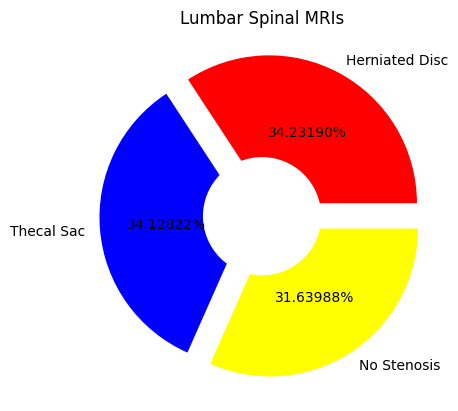

In [33]:
import matplotlib.pyplot as plt


# Setting size in Chart based on
# given values
sizes = [total_herniated_disc, total_thecal_sac, total_no_stenosis]

# Setting labels for items in Chart
labels = ["Herniated Disc", "Thecal Sac", "No Stenosis"]

# colors
colors = ['#FF0000', '#0000FF', '#FFFF00']

# explosion
explode = (0.10, 0.10, 0.10)

# Pie Chart
plt.pie(sizes, colors=colors, labels=labels,
		autopct='%1.1f%%', pctdistance=0.55,
		explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('Lumbar Spinal MRIs')

# Add Legends
# plt.legend(labels, loc="upper right")

# Displaying Chart
plt.show()


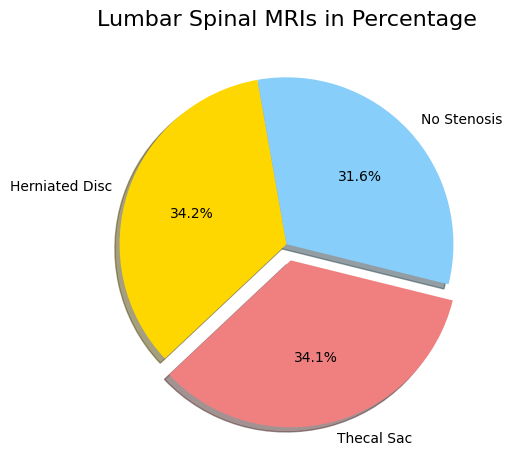

In [41]:
import matplotlib.pyplot as plt

# Data from the file
labels = ["Herniated Disc", "Thecal Sac", "No Stenosis"]
sizes = [total_herniated_disc, total_thecal_sac, total_no_stenosis]

# Colors
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0, 0.1, 0,)  # Explode the "Other" slice

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as circle
plt.title('Lumbar Spinal MRIs in Percentage', fontsize=16, pad=25)

# Save and show the chart
plt.savefig('example_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

### Unique patient's id from the given label.


In [ ]:
labels = []

for i in range(0, len(mri_dcm)):
  if mri_dcm[i]['label'] == 'No Stenosis':
   labels.append(mri_dcm[i]['patient_id'])

print(f"Unique Patient's ID: {set(labels)}")

Unique Patient's ID: {'10', '87', '177', '55', '133', '130', '60', '73', '132', '139', '94', '128', '157', '113', '70', '82', '80', '188', '90', '159', '32', '78', '9', '24', '180', '160', '64', '167', '165', '85', '101', '156', '179', '122', '98', '104', '116', '143', '2', '131', '161', '106', '18', '163', '46', '37', '117', '173', '147'}


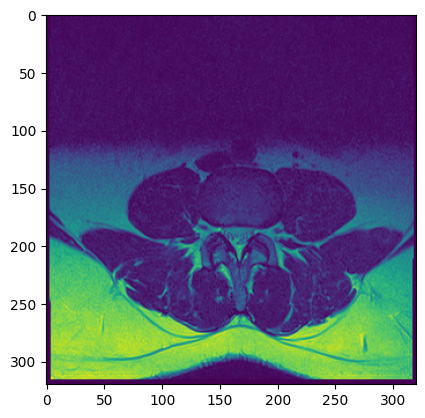

In [ ]:
# Load and show a single MRI

ds = dicom.dcmread(mri_dcm[0]['filePath'])

plt.imshow(ds.pixel_array)

In [ ]:
num_workers = os.cpu_count()
print(f"Using {num_workers} workers (ThreadPoolExecutor)")

Using 8 workers (ThreadPoolExecutor)


In [ ]:
import concurrent.futures
import time  # For timing comparison

# --- Function to read a single DICOM file ---
def read_dicom_pixel_data(item):
    """
    Reads a DICOM file and returns its pixel array and original index.
    Includes basic error handling.
    """
    index = item['original_index'] # We need to know which item this belongs to
    file_path = item['filePath']
    try:
        ds = dicom.dcmread(file_path)
        # Use ds.pixel_array directly, it's already a NumPy array
        pixel_array = ds.pixel_array
        return index, pixel_array
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        # Return None or raise an exception depending on desired handling
        return index, None

# --- Add original index to track items ---
for i, item in enumerate(mri_dcm):
    item['original_index'] = i

# --- Parallel Loading ---
# Determine the optimal number of workers
# os.cpu_count() is a good starting point, adjust based on testing
# For I/O bound tasks, you might even go slightly higher than CPU count
num_workers = os.cpu_count()
print(f"Using {num_workers} workers (ThreadPoolExecutor)")

# List to store results (index, pixel_data)
results = [None] * len(mri_dcm)

start_time = time.time()

# Use ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use executor.map to apply the function in parallel
    # tqdm can wrap the iterator for a progress bar
    # future_to_item = {executor.submit(read_dicom_pixel_data, item): item for item in mri_dcm}
    # for future in tqdm(concurrent.futures.as_completed(future_to_item), total=len(mri_dcm)):

    # Simpler approach with map (preserves order implicitly if inputs are ordered)
    # Note: map might be slightly less flexible with error handling per item
    # Let's stick to submit/as_completed for better error handling visibility and flexibility
    future_results = {executor.submit(read_dicom_pixel_data, item): i for i, item in enumerate(mri_dcm)}

    # Use tqdm for progress if installed
    try:
        from tqdm import tqdm
        iterator = tqdm(concurrent.futures.as_completed(future_results), total=len(mri_dcm))
    except ImportError:
        iterator = concurrent.futures.as_completed(future_results)
        print("Install tqdm for progress bar: pip install tqdm")


    for future in iterator:
        original_index, pixel_data = future.result()
        if pixel_data is not None:
            # Store the result directly back into the original dictionary
            mri_dcm[original_index]['read_new_image'] = pixel_data
        else:
            # Handle the error case (e.g., mark it, log it)
            mri_dcm[original_index]['read_new_image'] = None # Or some other indicator
            mri_dcm[original_index]['error'] = "Failed to read"

end_time = time.time()
print(f"ThreadPoolExecutor loading took: {end_time - start_time:.2f} seconds")

# Clean up the temporary index if needed
# for item in mri_dcm:
#    del item['original_index']

Using 8 workers (ThreadPoolExecutor)


100%|██████████| 5787/5787 [00:24<00:00, 232.18it/s]

ThreadPoolExecutor loading took: 25.43 seconds


In [ ]:
mri_dcm[0]

{'filePath': '/content/drive/MyDrive/thesis/Datasets/lumbar_spinal_cord_mri_datasets/datasets/1/L-SPINE_LSS_20160309_091629_240000/T2_TSE_TRA_384_0004/T2_TSE_TRA__0001_004.ima',
 'patient_id': '1',
 'label': 'Herniated Disc',
 'original_index': 0,
 'read_new_image': array([[ 0,  2,  2, ...,  2,  1,  1],
        [ 0,  1,  3, ...,  1,  1,  0],
        [ 0,  1,  1, ...,  0,  1,  1],
        ...,
        [ 0,  0,  0, ...,  3,  0,  0],
        [ 0, 13,  0, ...,  0,  0,  7],
        [ 0,  9, 13, ...,  4,  8,  5]], dtype=uint16)}

In [ ]:
# for i in range(0, len(mri_dcm)):
#   ds = dicom.dcmread(mri_dcm[i]['filePath'])
#   mri_dcm[i]['read_new_image'] = imageio.Array(ds.pixel_array)

In [ ]:
# get the all images height and width

def get_w_h(mri_list):
  w = []
  h = []
  for i in range(0, len(mri_list)):
    w.append(mri_list[i]['read_new_image'].shape[0])
    h.append(mri_list[i]['read_new_image'].shape[1])

  return h, w

w, h = get_w_h(mri_dcm)
print(f"Height: {set(w)}")
print(f"Width: {set(h)}")
print(len(mri_dcm))

Height: {320, 640, 384}
Width: {320, 640, 384, 310}
5787


In [ ]:
# import pydicom
# import numpy as np
# import gc

# def optimized_dicom_loader(mri_list, batch_size=20):
#     """
#     Memory-efficient DICOM loader for Colab with:
#     - Batch processing
#     - In-place memory management
#     - Error handling
#     """

#     for batch_start in range(0, len(mri_list), batch_size):
#         batch = mri_list[batch_start:batch_start + batch_size]

#         for idx, item in enumerate(batch, start=batch_start):
#             try:
#                 # 1. Memory-mapped reading with context manager
#                 with dicom.dcmread(item['filePath'],
#                                    defer_size='512 KB',  # Reduced metadata load
#                                    force=True) as ds:

#                     # 2. Direct pixel array conversion to optimized dtype
#                     pixel_array = ds.pixel_array.astype(np.uint16)

#                     # 3. Handle MONOCHROME1 inversion without copy
#                     if ds.PhotometricInterpretation == 'MONOCHROME1':
#                         np.subtract(np.iinfo(pixel_array.dtype).max,
#                                   pixel_array,
#                                   out=pixel_array)

#                     # 4. Store in original structure
#                     mri_dcm[idx]['read_new_image'] = pixel_array

#                     # 5. Cleanup within context manager
#                     del ds

#             except Exception as e:
#                 print(f"Error loading {item['filePath']}: {str(e)}")
#                 mri_dcm[idx]['read_new_image'] = None

#         # 6. Aggressive memory cleanup
#         del batch
#         gc.collect()

# # Usage (monitor memory with Colab's RAM manager)
# optimized_dicom_loader(mri_dcm, batch_size=20)

# # Optional: Verify first few entries
# print("Sample loaded image shape:", mri_dcm[0]['read_new_image'].shape)

### Show Individual Patient's MRI

Show the individual patient's MRI i.e. Herniated Disc, No Stenosis, Fecet Joint, Foramen, Thecal Sac

In [ ]:
print(f"Unique Herniated Disc Patient IDs: {list(df['herniated_disc'])}")
print(f"Unique No Stenosis Patient IDs: {list(df['no_stenosis'])}")
print(f"Unique Facet Joint Patient IDs: {list(df['facet_joint'])}")
print(f"Unique Foramen Patient IDs: {list(df['foramen'])}")
print(f"Unique Thecal Sac Patient IDs: {list(df['thecal_sac'])}")

Unique Herniated Disc Patient IDs: [1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 11.0, 33.0, 43.0, 44.0, 56.0, 58.0, 65.0, 69.0, 71.0, 72.0, 75.0, 81.0, 83.0, 86.0, 92.0, 93.0, 96.0, 97.0, 100.0, 103.0, 114.0, 115.0, 118.0, 119.0, 123.0, 124.0, 125.0, 126.0, 127.0, 137.0, 140.0, 144.0, 145.0, 146.0, 148.0, 149.0, 150.0, 151.0, 152.0, 155.0, 162.0, 168.0, 171.0, 175.0, 176.0, 186.0, 187.0, 195.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [ ]:
random_single_patient_herniated_disc = []
random_single_patient_no_stenosis = []
random_single_patient_facet_joint = []
random_single_patient_foramen = []
random_single_patient_thecal_sac = []

patient_herniated_disc = 1
patient_no_stenosis = 2
patient_facet_joint = 20
patient_foramen = 13
patient_thecal_sac = 12
random_no = 12

def get_patient_herniated_disc(patient_id):
  for mri_images in mri_dcm:
    if mri_images['patient_id'] == str(patient_id):
      random_single_patient_herniated_disc.append(mri_images['read_new_image'])

def get_patient_no_stenosis(patient_id):
  for mri_images in mri_dcm:
    if mri_images['patient_id'] == str(patient_id):
      random_single_patient_no_stenosis.append(mri_images['read_new_image'])

def get_patient_facet_joint(patient_id):
  for mri_images in mri_dcm:
    if mri_images['patient_id'] == str(patient_id):
      random_single_patient_facet_joint.append(mri_images['read_new_image'])

def get_patient_foramen(patient_id):
  for mri_images in mri_dcm:
    if mri_images['patient_id'] == str(patient_id):
      random_single_patient_foramen.append(mri_images['read_new_image'])

def get_patient_thecal_sac(patient_id):
  for mri_images in mri_dcm:
    if mri_images['patient_id'] == str(patient_id):
      random_single_patient_thecal_sac.append(mri_images['read_new_image'])

get_patient_herniated_disc(patient_herniated_disc)
get_patient_no_stenosis(patient_no_stenosis)
get_patient_facet_joint(patient_facet_joint)
get_patient_foramen(patient_foramen)
get_patient_thecal_sac(patient_thecal_sac)

In [ ]:
# Show the individual patient's five types stenosis.
from matplotlib.pyplot import figure, imshow, axis


def show_individual_patient_mri(images: list, \
                                cmap, \
                                rows=5, \
                                columns=4, \
                                labels=None, \
                                figure_size: tuple = (15, 15) ):
  fig = figure()
  number_of_files = len(images)
  for i in range(number_of_files):
      a=fig.add_subplot(1,number_of_files,i+1)
      # image = imread(list_of_files[i])
      imshow(images[i],cmap=cmap)
      axis('off')

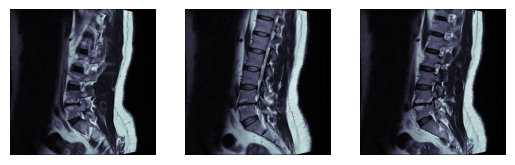

In [ ]:
show_individual_patient_mri(images=random_single_patient_herniated_disc[14:17], cmap=plt.cm.bone)

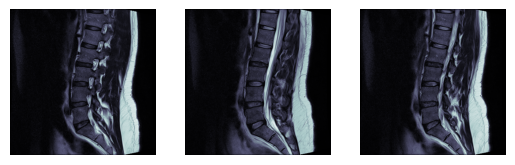

In [ ]:
show_individual_patient_mri(images=random_single_patient_no_stenosis[1:4], cmap=plt.cm.bone)

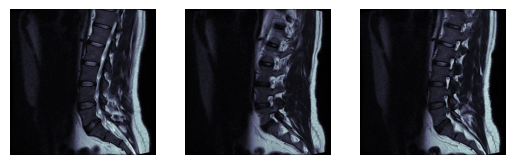

In [ ]:
show_individual_patient_mri(images=random_single_patient_thecal_sac[1:4], cmap=plt.cm.bone)

### Show all the different angles randomly of a single patient.

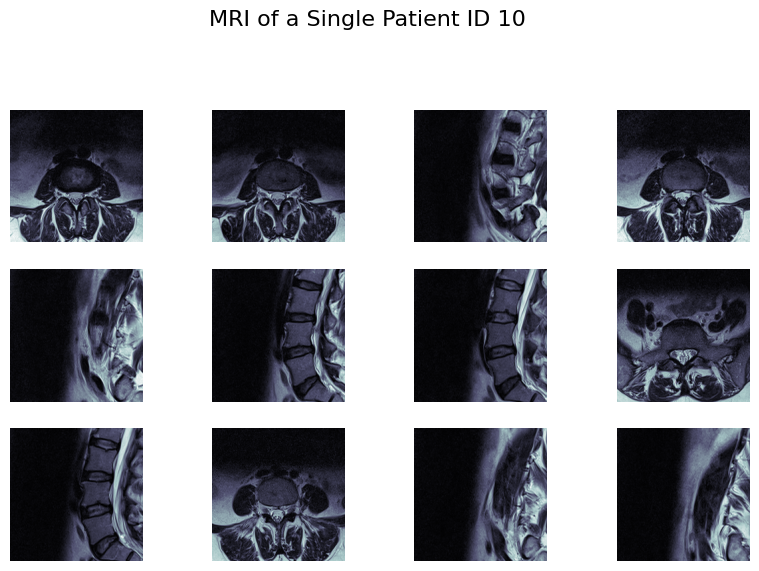

In [ ]:
# Show all the different angles randomly of a single patient.

randomly_single_patient_mri = []
random_no = 12
patient_id_ = 10
randomly_single_patient_mri.clear()

def show_all_spinal_cord_mris(images: list, cmap, rows=5, columns=4, labels=None, figure_size: tuple = (10, 10) ):
  """
    show all the spinal cord MRI images in a single row
  """
  w = 5
  h = 5
  fig = plt.figure(figsize=figure_size)
  fig.suptitle(f'MRI of a Single Patient ID {patient_id_}', fontsize=16)
  columns = columns
  rows = rows
  for i in range(0, len(images)):

      if dicom.dataset.FileDataset == type(images[i]):
        midrow = images[i].Rows // 2
        midcol = images[i].Columns // 2
        pixel_values = images[i].pixel_array[midrow-100:midrow+100, midcol-100:midcol+100]
        hu = apply_modality_lut(pixel_values, images[i])
        fig.add_subplot(rows, columns, i+1)
        out = apply_voi_lut(hu, images[i], index=0)
        plt.axis('off')
        plt.imshow(out, cmap=cmap)
      else:
        midrow = images[i].shape[0] // 2
        midcol = images[i].shape[1] // 2
        pixel_values = images[i][midrow-100:midrow+100, midcol-100:midcol+100]
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(pixel_values, cmap=cmap)
        if labels is not None:
         plt.title(labels[i])

  plt.show()

for mri_images in mri_dcm:
  if mri_images['patient_id'] == str(patient_id_):
    randomly_single_patient_mri.append(mri_images['read_new_image'])

list_of_random_items = random.sample(randomly_single_patient_mri, random_no)

show_all_spinal_cord_mris(list_of_random_items[:13], cmap=plt.cm.bone)

## **Masking (Remove Noise)**

Now, we need to clean all the noises from our MRIs. So, for this we have created a function called `remove_noise`, which would allow you to clean the dataset.

In [ ]:
def remove_noise(image: list, display=False):
  """Remove slice noise"""

  masked_ones = []
  mask = []
  new_images = []

  for i in range(0, len(image)):
    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 3x3, the pixel belongs to the same class
    # image_point =  imageio.imread(image[i]['filePath'])
    image_point = mri_dcm[i]['read_new_image']
    # image_point = np.array(image_point)
    # new_images.append(image_point)
    segmentation = morphology.dilation(image_point, np.ones((4, 4)))
    segmentation[segmentation < 25] = 0
    segmentation[segmentation > 25] = 1
    labels, label_nb = ndimage.label(segmentation)
    label_count = np.bincount(labels.ravel().astype(int))

    # The size of label_count is the number of classes/segmentations found.
    # The first class is not used since it's the background.
    label_count[0] = 0

    # A mask with the class with more pixels is created
    # since it should represent the Lumbar Spinal Stenosis
    label = labels == label_count.argmax()

    # Improve the lumbar spinal cord mask
    morphology_dilation = morphology.dilation(label, np.ones((5, 5)))
    morphology_dilation = ndimage.binary_fill_holes(morphology_dilation)
    morphology_dilation = morphology.dilation(morphology_dilation, np.ones((3, 3)))
    # mask.append(morphology_dilation)

    # Since the pixels in the mask are zeros and ones,
    # it is possible to multiple the original image to only keep the Lumbar Spinal Stenosis region
    masked_image = morphology_dilation * image_point
    mri_dcm[i]['masked_image'] = masked_image
    mri_dcm[i]['mask'] = morphology_dilation
    # masked_ones.append(masked_image)

remove_noise(mri_dcm, display=True)

In [ ]:
# # Before processing, ensure images are uint8
# for img_dict in mri_dcm:
#     img_dict['read_new_image'] = img_dict['read_new_image'].astype(np.uint8)

Show the ***original***, ***masked*** and ***new*** images

In [ ]:
def show_masked_image(image_point, mask, masked_image):
  plt.figure(figsize=(10, 2.5))
  plt.subplot(141)
  plt.imshow(image_point, cmap=plt.cm.bone)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(142)
  plt.imshow(mask, cmap=plt.cm.bone)
  plt.title('Mask')
  plt.axis('off')

  plt.subplot(143)
  plt.imshow(masked_image, cmap=plt.cm.bone)
  plt.title('Clean Image')
  plt.axis('off')

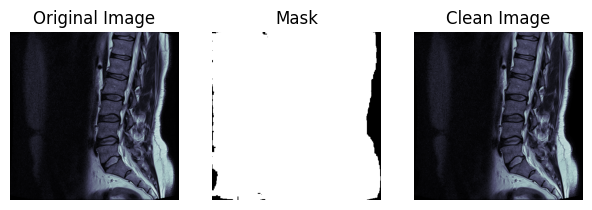

In [ ]:
show_masked_image(mri_dcm[120]['read_new_image'], \
                  mri_dcm[120]['mask'], \
                  mri_dcm[120]['masked_image'])

### **Resize the Image**


In [ ]:
mri_dcm[0]['masked_image'].shape

(320, 320)

#### (1) Resize all the masked images.


In [ ]:
def resize_images(images: list, new_key = None, key= None):

  # Initialize the new_width and new_height.
  new_width, new_height = [], []

  for image in range(0, len(images)):
    new_img = mri_dcm[image][key]
    new_width.append(new_img.shape[0])
    new_height.append(new_img.shape[1])
    resize_image = cv.resize(new_img, (new_img.shape[1] // 2, new_img.shape[0] // 2))
    resize_image = cv.resize(resize_image, (400, 400))
    mri_dcm[image][new_key] = resize_image

  return new_width, new_height

new_width, new_height = resize_images(mri_dcm, \
                                      new_key="resize_masked_image", \
                                      key="masked_image")
print(f"Unique Width: {set(new_width)}")
print(f"Unique Height: {set(new_height)}")

Unique Width: {320, 640, 384, 310}
Unique Height: {320, 640, 384}


In [ ]:
# Convert all the "resize_image" into RGB.

def convert_to_rgb(images: list):
  for image in range(0, len(images)):
    ds = images[image]['resize_masked_image'].astype(float)
    ds = (np.maximum(ds,0) / ds.max()) * 255.0
    images[image]['resize_masked_image'] = np.uint8(ds)
  return images

mri_dcm = convert_to_rgb(mri_dcm)

In [ ]:
mri_dcm[0]['resize_masked_image'].shape

(400, 400)

#### (2) Resize all the images after the reading them.

Show the **masked_image** after resizing the images.

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

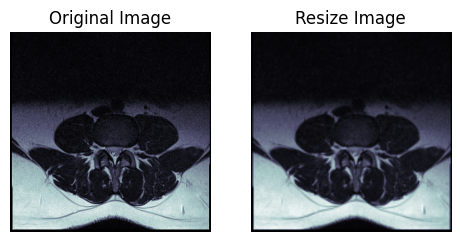

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(151)
plt.imshow(mri_dcm[0]['masked_image'], cmap=plt.cm.bone)
plt.title('Original Image')
plt.axis('off')
# plt.figure(figsize=(10, 2.5))
plt.subplot(152)
plt.imshow(mri_dcm[0]['resize_masked_image'], cmap=plt.cm.bone)
plt.title('Resize Image')
plt.axis('off')

## **Histrogram Equalization**

Some of the MRI images are blur and have less intensities. So in order to improve the intersisites we need to use **Histrogram Equalizer**.

In [ ]:
# Convert all the "resize_image" into RGB.

def convert_to_rgb(images: list, key=None):
  for image in range(0, len(images)):
    ds = mri_dcm[image][key].astype(float)
    ds = (np.maximum(ds,0) / ds.max()) * 255.0
    mri_dcm[image][key] = np.uint8(ds)

new_mri_dcm = convert_to_rgb(mri_dcm, key='resize_masked_image')

In [ ]:
# Applying Histrogram Equalization to increase the intensity

def apply_histrogram_equalization(images: list, key=None):
  for image in range(0, len(images)):
    mri_dcm[image]['histrogram_equalizer'] = cv.equalizeHist(mri_dcm[image][key])

new_mri_dcm = apply_histrogram_equalization(mri_dcm, key='resize_masked_image')

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

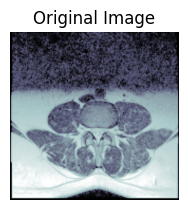

In [ ]:
plt.figure(figsize=(10, 2.5))
plt.subplot(141)
plt.imshow(mri_dcm[0]['histrogram_equalizer'], cmap=plt.cm.bone)
plt.title('Original Image')
plt.axis('off')

### **Image Augmentation**

We need to generate some new images by using image augmentation techniques like zoom (90% - 110%), rotation (0.09 radians), width and height shifting (90% - 110%)

In [ ]:
mri_dcm[0]['histrogram_equalizer'].shape

(400, 400)

Again we need to unified resizing the improved images.

In [ ]:
new_width, new_height = [], []

def resize_images(images: list):
  for image in range(0, len(images)):
    new_image = mri_dcm[image]['resize_masked_image']
    mri_dcm[image]['histrogram_equalization'] = cv.resize(new_image, (new_image.shape[1] // 2, new_image.shape[0] // 2))
    new_width.append(mri_dcm[image]['histrogram_equalization'].shape[1])
    new_height.append(mri_dcm[image]['histrogram_equalization'].shape[0])
  return images

new_mri_dcm = resize_images(mri_dcm)
print(f"New Unique Width: {set(new_width)}")
print(f"New Unique Height: {set(new_height)}")

New Unique Width: {200}
New Unique Height: {200}


Show the **resize_masked_image** and **histrogram_equalizer** to compare


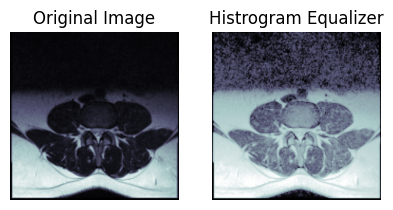

In [ ]:
def show_comparison(resize_masked_image, histrogram_equalizer, title_1, title_2):
  plt.figure(figsize=(10, 2.5))
  plt.subplot(141)
  plt.imshow(resize_masked_image, cmap=plt.cm.bone)
  plt.title(title_1)
  plt.axis('off')

  plt.subplot(142)
  plt.imshow(histrogram_equalizer, cmap=plt.cm.bone)
  plt.title(title_2)
  plt.axis('off')

show_comparison(mri_dcm[0]['resize_masked_image'], mri_dcm[0]['histrogram_equalizer'], 'Original Image', 'Histrogram Equalizer')

In [ ]:
# Find out the exact resizing the images on the basis of 90%-110% for zooming

def new_dimensions(width, height, percentage):
  min_dimension = min(width, height)
  result = max(min_dimension * (percentage / 100), 0)
  newHeight=(result/min_dimension) * height;
  newWidth=(result/min_dimension) * width;
  return newWidth, newHeight

In [ ]:
new_width = []
new_height = []

def zoom_images(images: list):
  for i in range(0, len(images)):
    new_images = mri_dcm[i]['resize_masked_image']
    newWidth, newHeight = new_dimensions(new_images.shape[1], new_images.shape[0], 50)
    mri_dcm[i]['resize_masked_image'] = cv.resize(new_images, (int(newWidth), int(newHeight)))
    new_width.append(newWidth)
    new_height.append(newHeight)

# zoom_images(mri_dcm)

print(f"New Unique Width: {set(new_width)}")
print(f"New Unique Height: {set(new_height)}")

New Unique Width: set()
New Unique Height: set()


(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

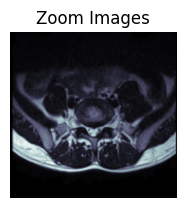

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(161)
plt.imshow(mri_dcm[110]['resize_masked_image'], cmap=plt.cm.bone)
plt.title('Zoom Images')
plt.axis('off')


In [ ]:
def clipped_zoom(img: list, zoom_factor, **kwargs):
    for image in range(0, len(img)):
      h, w = mri_dcm[image]['resize_masked_image'].shape[:2]

      # For multichannel images we don't want to apply the zoom factor to the RGB
      # dimension, so instead we create a tuple of zoom factors, one per array
      # dimension, with 1's for any trailing dimensions after the width and height.
      zoom_tuple = (zoom_factor,) * 2 + (1,) * (mri_dcm[image]['resize_masked_image'].ndim - 2)

      # Zooming out
      if zoom_factor < 1:

          # Bounding box of the zoomed-out image within the output array
          zh = int(np.round(h * zoom_factor))
          zw = int(np.round(w * zoom_factor))
          top = (h - zh) // 2
          left = (w - zw) // 2

          # Zero-padding
          out = np.zeros_like(mri_dcm[image]['resize_masked_image'])
          out[top:top+zh, left:left+zw] = zoom(mri_dcm[image]['resize_masked_image'], zoom_tuple, **kwargs)

      # Zooming in
      elif zoom_factor > 1:

          # Bounding box of the zoomed-in region within the input array
          zh = int(np.round(h / zoom_factor))
          zw = int(np.round(w / zoom_factor))
          top = (h - zh) // 2
          left = (w - zw) // 2

          out = zoom(mri_dcm[image]['resize_masked_image'][top:top+zh, left:left+zw], zoom_tuple, **kwargs)

          # `out` might still be slightly larger than `img` due to rounding, so
          # trim off any extra pixels at the edges
          trim_top = ((out.shape[0] - h) // 2)
          trim_left = ((out.shape[1] - w) // 2)
          out = out[trim_top:trim_top+h, trim_left:trim_left+w]

      # If zoom_factor == 1, just return the input array
      else:
          out = mri_dcm[image]['zoom_image']
      mri_dcm[image]['zoom_image'] = out

zoomed = clipped_zoom(mri_dcm, 1.55)


(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

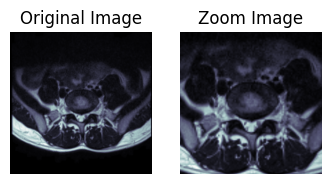

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(171)
plt.imshow(mri_dcm[110]['resize_masked_image'], cmap=plt.cm.bone)
plt.title('Original Image')
plt.axis('off')

plt.subplot(172)
plt.imshow(mri_dcm[110]['zoom_image'], cmap=plt.cm.bone)
plt.title('Zoom Image')
plt.axis('off')

In [ ]:
mri_dcm[0]['resize_masked_image'].shape

(400, 400)

Spliting the dataset into **training** and **testing** with **70%** and **30%** respectively.

In [ ]:
training, testing = [], []

train, test = np.split(mri_dcm,[int(0.80 * len(mri_dcm))])

In [ ]:
len(train), len(test)

(4629, 1158)

Saving the final preprocessed images into the **training** and **testing** with the

In [ ]:
type(mri_dcm[0]['resize_masked_image'])

numpy.ndarray

In [ ]:
from typing import List, Dict, Any, Optional

# Define the kernel globally so it's accessible by worker processes
SHARPEN_KERNEL = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

def _process_single_image_for_parallel(image_dict: Dict[str, Any],
                                       h: float,
                                       template_win_size: int,
                                       search_win_size: int) -> Dict[str, Any]:
    """
    Helper function to process a single image dictionary.
    Designed to be called by a parallel executor.
    """
    try:
        image_gray = image_dict['resize_masked_image']
        image_bgr = cv.cvtColor(image_gray, cv.COLOR_GRAY2BGR)
        sharpened_img = cv.filter2D(image_bgr, -1, SHARPEN_KERNEL) # Access global kernel
        deblurred_img = cv.fastNlMeansDenoisingColored(
            sharpened_img, None, h, h, template_win_size, search_win_size
        )

        # Return a *new* dictionary with the result included
        # This avoids potential issues with modifying shared state in parallel
        result_dict = image_dict.copy()
        result_dict['unblur'] = deblurred_img
        return result_dict

    except KeyError:
        print(f"Warning: 'resize_masked_image' key not found. Returning original dict.")
        return image_dict # Return original if key missing
    except Exception as e:
        print(f"Error processing image in worker: {e}. Returning original dict.")
        return image_dict # Return original if error during processing


def deblurred_parallel(images: List[Dict[str, Any]],
                       h: float = 10,
                       template_win_size: int = 7,
                       search_win_size: int = 21,
                       max_workers: Optional[int] = None) -> List[Dict[str, Any]]:
    """
    Applies sharpening and denoising to a list of images in parallel.

    Args:
        images: A list of dictionaries, each containing an image under the key
                'resize_masked_image' (expected to be grayscale).
        h: Parameter regulating filter strength for luminance component in denoising.
        template_win_size: Size of the template patch for denoising. (Default: 7)
        search_win_size: Size of the window used for denoising. (Default: 21)
        max_workers: The maximum number of processes to use. If None, it defaults
                     to the number of processors on the machine.

    Returns:
        A *new* list containing the processed dictionaries, each including
        the deblurred image under the key 'unblur'.
    """
    if max_workers is None:
        max_workers = os.cpu_count()
        print(f"Using {max_workers} workers for parallel processing.")

    processed_images = []
    # Use ProcessPoolExecutor for CPU-bound tasks like image processing
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Create futures for each image processing task
        # We use partial or lambda to pass the fixed parameters (h, etc.)
        futures = [executor.submit(_process_single_image_for_parallel,
                                  img_dict, h, template_win_size, search_win_size)
                   for img_dict in images]

        # Collect results as they complete
        # Use tqdm here for progress bar if you have many images:
        # from tqdm import tqdm
        # for future in tqdm(concurrent.futures.as_completed(futures), total=len(images)):
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            try:
                processed_images.append(future.result())
                # Basic progress indication
                if (i + 1) % 100 == 0:
                     print(f"Processed {i+1}/{len(images)} images...")
            except Exception as e:
                # Handle potential errors raised from the future/worker
                print(f"Error retrieving result from worker: {e}")
                # Decide how to handle: append None, original dict, or skip?
                # Appending None or the original might require downstream checks.
                # For simplicity, we might just log and skip appending here,
                # or append the original dict if returned by the worker on error.
                # The current _process_single_image_for_parallel returns original on error.


    print(f"Finished processing {len(processed_images)} images.")
    # Note: as_completed does not guarantee order. If order is critical,
    # you should use executor.map or re-sort the results based on the original order.
    # Using map (simpler if order matters and error handling is basic):
    # with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    #    from functools import partial
    #    process_func = partial(_process_single_image_for_parallel,
    #                           h=h, template_win_size=template_win_size,
    #                           search_win_size=search_win_size)
    #    processed_images = list(executor.map(process_func, images))

    # If using as_completed and order is essential, you'd need a way to map results
    # back to their original positions, e.g., by passing an index or unique ID.
    # For simplicity, assuming order might not be strictly required or `map` is used.

    return processed_images


# --- Example Usage ---
# Assuming 'train' and 'test' lists exist as before

try:
    # if 'train' not in locals() or not isinstance(train, list):
    #      print("Creating dummy train data")
    #      dummy_gray = np.random.randint(0, 256, (100, 100), dtype=np.uint8)
    #      train = [{'resize_masked_image': dummy_gray.copy()} for _ in range(500)] # More data for parallel demo
    # if 'test' not in locals() or not isinstance(test, list):
    #      print("Creating dummy test data")
    #      dummy_gray = np.random.randint(0, 256, (100, 100), dtype=np.uint8)
    #      test = [{'resize_masked_image': dummy_gray.copy()} for _ in range(200)] # More data for parallel demo

    print("Processing train set (parallel)...")
    # Note: This returns a new list, so reassign it
    train = deblurred_parallel(train)
    print("Processing test set (parallel)...")
    # Note: This returns a new list, so reassign it
    test = deblurred_parallel(test)
    print("Parallel processing finished.")
    # Verify results (optional)
    if train:
        print(f"Train set (processed) item 0 keys: {train[0].keys()}")
    if test:
        print(f"Test set (processed) item 0 keys: {test[0].keys()}")

except NameError:
    print("Error: 'train' or 'test' variables not defined.")
except Exception as e:
    print(f"An error occurred during parallel processing: {e}")

Processing train set (parallel)...
Using 8 workers for parallel processing.
Processed 100/4629 images...
Processed 200/4629 images...
Processed 300/4629 images...
Processed 400/4629 images...
Processed 500/4629 images...
Processed 600/4629 images...
Processed 700/4629 images...
Processed 800/4629 images...
Processed 900/4629 images...
Processed 1000/4629 images...
Processed 1100/4629 images...
Processed 1200/4629 images...
Processed 1300/4629 images...
Processed 1400/4629 images...
Processed 1500/4629 images...
Processed 1600/4629 images...
Processed 1700/4629 images...
Processed 1800/4629 images...
Processed 1900/4629 images...
Processed 2000/4629 images...
Processed 2100/4629 images...
Processed 2200/4629 images...
Processed 2300/4629 images...
Processed 2400/4629 images...
Processed 2500/4629 images...
Processed 2600/4629 images...
Processed 2700/4629 images...
Processed 2800/4629 images...
Processed 2900/4629 images...
Processed 3000/4629 images...
Processed 3100/4629 images...
Pro

In [ ]:
# # https://github.com/navyajain16/Image-Deblurring

# def deblurred(images):

#   for i in range(0, len(images)):
#     image = images[i]['resize_masked_image']
#     sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#     sharpen = cv.filter2D(cv.cvtColor(image, cv.COLOR_GRAY2BGR), 0 , sharpen_kernel)

#     deblurred = cv.fastNlMeansDenoisingColored(sharpen,None,10,10,7,21)
#     images[i]['unblur'] = deblurred

#   return images

# train = deblurred(train)
# test = deblurred(test)

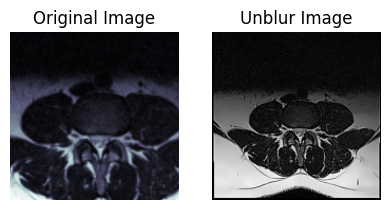

In [ ]:
show_comparison(train[0]['zoom_image'], train[0]['unblur'], 'Original Image', "Unblur Image")

In [ ]:
# saving_images_path = '/content/drive/MyDrive/thesis/Datasets/lumbar_spinal_cord_mri_datasets/preprocessed_images/final_preprocessed'

# if not os.path.exists(saving_images_path):
#   print(f"Creating a new folder: {saving_images_path}")
#   os.makedirs(saving_images_path)

# def save_final_preprocessed(images: list, main_label: str):

#   for i in range(0, len(images)):
#     histrogram_image = Image.fromarray(images[i]['unblur'])

#     if not os.path.exists(f"{saving_images_path}/{main_label}/{images[i]['label']}"):
#       os.makedirs(f"{saving_images_path}/{main_label}/{images[i]['label']}")

#     if os.path.isfile(f"{saving_images_path}/{main_label}/{images[i]['label']}/image_{i+1}.jpg"):
#       os.remove(f"{saving_images_path}/{main_label}/{images[i]['label']}/image_{i+1}.jpg")
#       histrogram_image.save(f"{saving_images_path}/{main_label}/{images[i]['label']}/image_{i+1}.jpg")

#       data = {'patient_id': images[i]['patient_id'], \
#               'path': f"{saving_images_path}/{main_label}/{images[i]['label']}/image_{i+1}.jpg"}
#       data = {k:[v] for k,v in data.items()}  # WORKAROUND
#       df = pd.DataFrame(data)
#       if not os.path.isfile(f'{saving_images_path}/patient_dataset_details.csv'):
#         df.to_csv(f'{saving_images_path}/patient_dataset_details.csv', index=False)
#       else:
#         # df.update(data)
#         df.to_csv(f'{saving_images_path}/patient_dataset_details.csv', mode='a', index=False, header=False)
#     else:
#       histrogram_image.save(f"{saving_images_path}/{main_label}/{images[i]['label']}/image_{i+1}.jpg")

#       data = {'patient_id': images[i]['patient_id'], \
#               'path': f"{saving_images_path}/{main_label}/{images[i]['label']}/image_{i+1}.jpg"}
#       data = {k:[v] for k,v in data.items()}  # WORKAROUND
#       df = pd.DataFrame(data)
#       if not os.path.isfile(f'{saving_images_path}/patient_dataset_details.csv'):
#         df.to_csv(f'{saving_images_path}/patient_dataset_details.csv', index=False)
#       else:
#         # df.update(data)
#         df.to_csv(f'{saving_images_path}/patient_dataset_details.csv', mode='a', index=False, header=False)

# save_final_preprocessed(train, "training")
# save_final_preprocessed(test, "testing")